<h1>Edge Detection, Morphological Processing and Digital Halftoning</h1>

<h3>Problem 1: Edge Detection (30%)</h3>
<p>An edge map is a binary image, where 0 implies the edge, and 255 implies the background.Please perform edge detection on the two images in Figure 1 (i.e., building.raw and building_noise.raw) and show the edge map results in your report.</p>
<p>(a) Basic edge detection algorithms.Please implement two basic edge detection algorithms: the 1st-order derivative gradient method and the 2nd-order derivative plus zero crossing. Please discuss how you choose the threshold values which are required in each of the two algorithms.</p>
<p>(b) Advanced edge detection algorithms. Please implement some pre-processing and post-processing tools to improve the results from (a). For example, you might want to enhance the contrast of Figure 1(a) and perform noise removal on Figure 1(b). State your pre-processing and post-processing steps clearly in your report and explain how they help in your obtained edge detection results.</p>


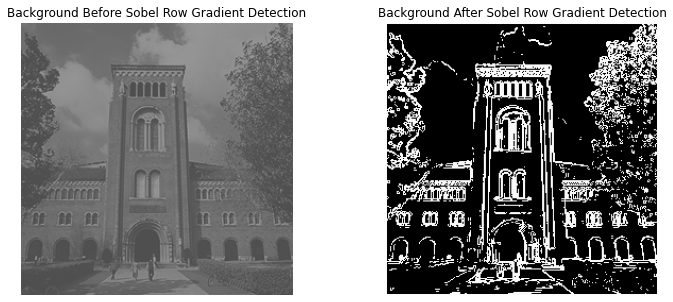

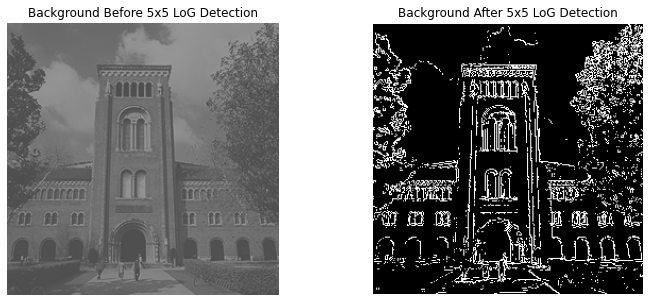

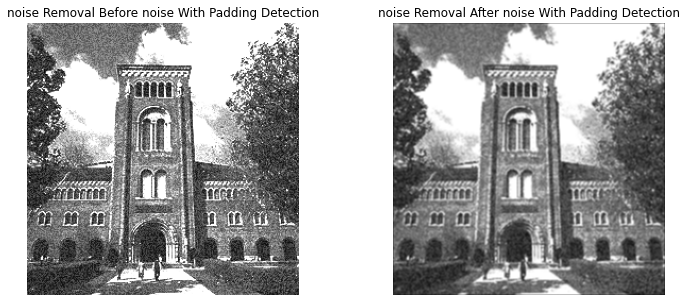

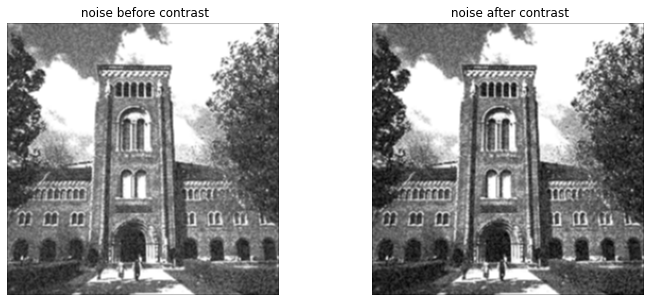

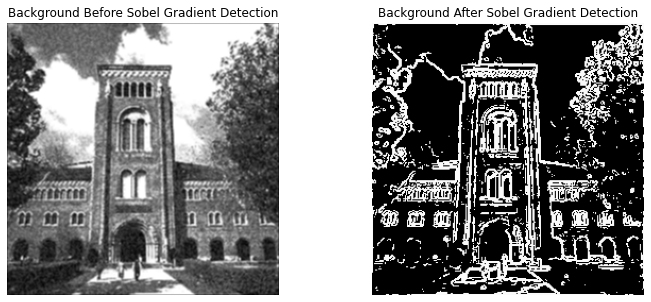

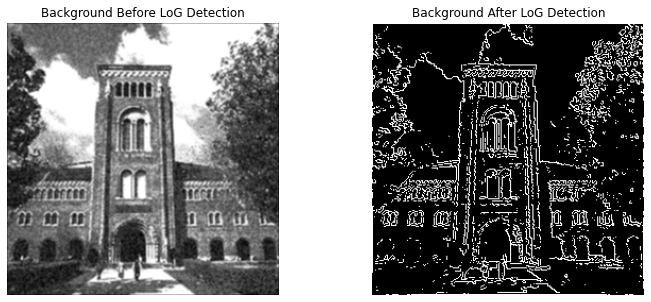

In [124]:
#Problem 1: Edge Detection
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
def readraw_color(filename, width, height, num_channels): 
    dtype = np.uint8
    with open(filename, 'rb') as f:
        raw_image_data = np.frombuffer(f.read(), dtype=dtype)
    image_data = raw_image_data.reshape((height, width, num_channels))
    return image_data.tolist()
def grayscale(pic):
    for i in range(0, len(pic)): 
        for a in range(0, len(pic[0])):   
            Y = pic[i][a][0]
            pic[i][a].append(Y)
            pic[i][a].append(Y)
def plot_img(img, title, directory):
    plt.imshow(img)
    plt.title(title) 
    plt.axis('off')
building = readraw_color('./Project2_Images/building.raw', 256, 256, 1)
grayscale(building)
def padding(img, mask_coef, y, x, noise, col, thres, dev):
    mask_1 = int(np.sqrt(len(mask_coef)))
    half_mask_size_1 = mask_1 // 2
    result = [0, 0, 0] if col else 0
    k = 0

    for i in range(-half_mask_size_1, half_mask_size_1 + 1):
        for j in range(-half_mask_size_1, half_mask_size_1 + 1):
            y_x = y+i
            x_x = x+j
            pixel_value = img[y_x][x_x] if 0 <= y_x < len(img) and 0 <= x_x < len(img[0]) else ([0, 0, 0] if col else [0])
            result += pixel_value[0] * mask_coef[k]
            k += 1
    result = result / dev
        
    return result

def edge_det(img, pic, mask_coef, mask_2, title, dev, noise=True, col=False, thres=200):
    detected_x = copy.deepcopy(img)
    detected_y = copy.deepcopy(img)
    for i in range(len(detected_x)):
        for j in range(len(detected_x[0])):
            Y = padding(img, mask_coef, i, j, noise, col, thres, dev)
            for c in range(3):
                detected_x[i][j][c] = Y
    for i in range(len(detected_y)):
        for j in range(len(detected_y[0])):
            Y = padding(img, mask_2, i, j, noise, col, thres, dev)
            for c in range(3):
                detected_y[i][j][c] = Y
    magnitude = copy.deepcopy(img)

    for i in range(len(magnitude)):
        for j in range(len(magnitude[0])):
            for c in range(3):
                Gx = detected_x[i][j][c]
                Gy = detected_y[i][j][c]
                mag = math.sqrt(Gx**2 + Gy**2)
                if mag > thres:
                    magnitude[i][j][c] = 250
                else:
                    magnitude[i][j][c] = 0
    padding_difference(img, magnitude, pic, title)
    return magnitude
def padding_difference(img, image_without_noise, pic, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title(f'{pic} Before {title} Detection')
    
    axs[1].imshow(image_without_noise)
    axs[1].axis('off')
    axs[1].set_title(f'{pic} After {title} Detection')
    plt.show()  
dev = 4
thres = 17.5
coef_x = [1, 0, -1, 2, 0, -2, 1, 0, -1]
coef_y = [-1, -2, -1, 0, 0, 0, 1, 2, 1]
sobel_fist = edge_det(building, "Background",title="Sobel Row Gradient", dev=dev, mask_coef=coef_x, mask_2=coef_y, thres=thres)
def calc_int(image1, image2):
    return np.logical_and(np.array(image1), np.array(image2)).astype(np.uint8) * 255
 
def second_der_on_edge_detection(img, pic, mask_coefficients, title, deviation, sobel_fist, noise=True, col=False, thres = 200):
    img_edge_detected = copy.deepcopy(img)
    for i in range(len(img_edge_detected)):
        for j in range(len(img_edge_detected[0])):
            Y = padding(img, mask_coefficients, i, j, noise, col, thres, deviation)
            for c in range(3):
                img_edge_detected[i][j][c] = Y
    for i in range(1, len(img_edge_detected)-1):
        for j in range(1, len(img_edge_detected[0])-1):
            
            for c in range(3):
                current_pixel = img_edge_detected[i][j][c]
                right_pixel = img_edge_detected[i][j+1][c]
                bottom_pixel = img_edge_detected[i+1][j][c]
                if (current_pixel * right_pixel < 0) or (current_pixel * bottom_pixel < 0):
                    Y = 255
                else:
                    Y = 0
                img_edge_detected[i][j][c] = Y
    
    imp = calc_int(sobel_fist, img_edge_detected)
    padding_difference(img, imp, pic, title)
 
    return img_edge_detected
second_dev_mask = [0, 0, -1, 0, 0, 0, -1, -2, -1, 0, -1, -2, 16, -2, -1, 0, -1, -2, -1, 0, 0, 0, -1, 0, 0]


second_der_on_edge_detection(building, "Background",title="5x5 LoG", deviation=1, mask_coefficients=second_dev_mask, sobel_fist=sobel_fist)
building_noise = readraw_color('./Project2_Images/building_noise.raw', 256, 256, 1)
grayscale(building_noise)
def mask_padding_noise(img, mask_coefficients, y, x, noise, col):
    mask_size = int(np.sqrt(len(mask_coefficients)))
    half_mask_size = mask_size // 2
    result = [0, 0, 0] if col else 0
    k = 0

    for i in range(-half_mask_size, half_mask_size + 1):
        for j in range(-half_mask_size, half_mask_size + 1):
            y_x = y+i
            x_x = x+j
            pixel_value = None
            if 0 <= y_x < len(img) and 0 <= x_x < len(img[0]):
                pixel_value = img[y_x][x_x]
            else:
                if col:
                    pixel_value = [0, 0, 0]
                else:
                    pixel_value = [0]

            if col:
                for c in range(3):
                    result[c] += pixel_value[c] * coef[k]
            else:
                result += pixel_value[0] * coef[k]
                
            k += 1
    if noise:
        if col:
            for c in range(3):
                result[c] = result[c] / sum(coef)
        else:
            result = result / sum(coef)

    if col:
        return [int(val) for val in result]
    else:
        return int(result)

def padding_noise(img, pic, mask_coef, title='noise with padding', noise=True, col=False):
    image_without_noise = copy.deepcopy(img)

    for i in range(len(image_without_noise)):
        for j in range(len(image_without_noise[0])):
            Y = mask_padding_noise(img, mask_coef, i, j, noise, col)
            if col:
                for c in range(3):
                    image_without_noise[i][j][c] = Y[c]
            else:
                for c in range(3):
                    image_without_noise[i][j][c] = Y

    padding_difference(img, image_without_noise, pic, title)
    return image_without_noise
def histogram(img):
    pixel_values = np.array(img).flatten()
    histogram = [0] * 256
    for pixel in pixel_values:
        histogram[pixel] += 1
    
    return histogram
def image_histogram(img):
    pixel_values = np.array(img).flatten()
    histogram = [0] * 256
    for pixel in pixel_values:
        histogram[pixel] += 1
    
    return histogram
def fmin(histogram):
    for idx in range(0, len(histogram)):
        if histogram[idx] != 0:
            return idx  
def fmax(histogram):
    for idx in range(len(histogram)-1, -1, -1):
        if histogram[idx] != 0:
            return idx
def h(F, Fmin, Fmax, Gmin, Gmax):
    slope = 255 / (Fmax - Fmin)
    x = (F - Fmin)
    b = Gmin
    return int(slope * x + b)
def linear_contrast(img, pic):
    img_enhance = copy.deepcopy(img)
    hist = image_histogram(img_enhance)
    Fmin = fmin(hist)
    Fmax = fmax(hist)
    gmax = 255
    gmin = 0
    lst = []

    for i in range(0, len(img_enhance)): 
        for a in range(0, len(img_enhance[0])):
            Y = h(img_enhance[i][a][0], Fmin, Fmax, gmin, gmax)
            lst.append([Y, img_enhance[i][a][0]])
            if Y > gmax:
                Y = gmax
            elif Y < gmin:
                Y = gmin
            img_enhance[i][a][0] = Y
            img_enhance[i][a][1] = Y
            img_enhance[i][a][2] = Y
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[1].imshow(img_enhance)
    axs[1].axis('off')
    axs[1].set_title(f'{pic} after contrast')
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title(f'{pic} before contrast')
    plt.show()
    return img_enhance

coef = [1, 2,1,
        2, 4, 2,
        1, 2, 1]
remove_noise = padding_noise(building_noise, "noise Removal", coef)
img_enhenced = linear_contrast(remove_noise, " noise")
deviation = 4
thres = 45
sob_n = edge_det(img_enhenced, "Background",title="Sobel Gradient", dev=deviation, mask_coef=coef_x, mask_2=coef_y, thres=thres)
second_der_on_edge_detection(img_enhenced, "Background",title="LoG", deviation=1, mask_coefficients=second_dev_mask, sobel_fist=sob_n)
second_dev_mask = [0, 0, -1, 0, 0, 
                   0, -1, -2, -1, 0,
                  -1, -2, 16, -2, -1, 
                   0, -1, -2, -1, 0,
                   0, 0, -1, 0, 0]



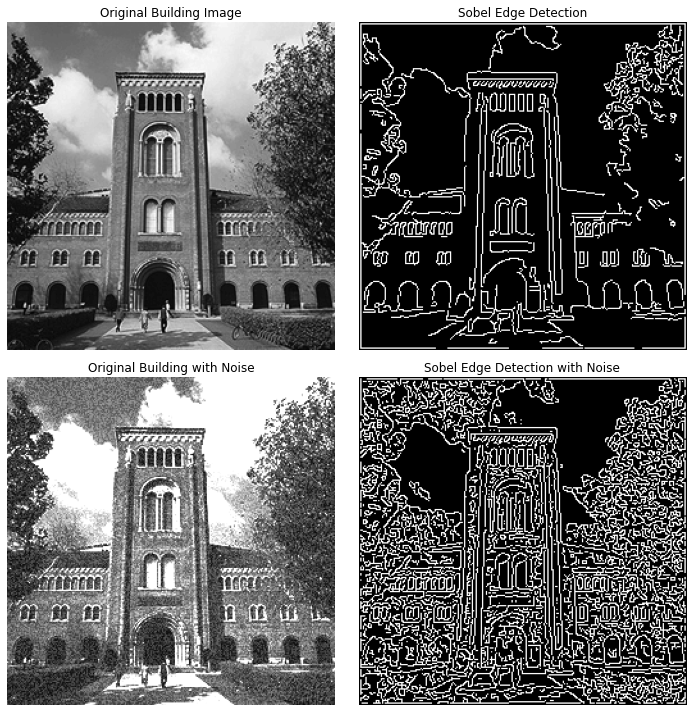

In [11]:
#DONOT USE THIS FOR GRADING THE HW
#Advanced edge detection уalgorithms

import numpy as np
from scipy import ndimage
from skimage import feature
import matplotlib.pyplot as plt

# Consolidating the edge detection methods into one with a parameter to switch between methods
def edge_detection(image, method='sobel', sigma=1.0):
    if method == 'sobel':
        return feature.canny(image, sigma=sigma)
    elif method == 'log':
        blurred = ndimage.gaussian_filter(image, sigma=sigma)
        laplacian = ndimage.laplace(blurred)
        zero_crossings = np.where(np.diff(np.sign(laplacian), axis=0), 1, 0)
        return zero_crossings

# We load the images only once as they are used multiple times.
# We also pass the shape as a parameter to make the function more general.
def load_and_process_image(file_path, shape=(256, 256), method='sobel', sigma=1.0):
    try:
        # Load image from file
        with open(file_path, 'rb') as rawfile:
            img = np.fromfile(rawfile, dtype=np.uint8).reshape(shape)
        # Process image
        edges = edge_detection(img, method=method, sigma=sigma)
        return img, edges
    except IOError:
        print(f"Error: File {file_path} not accessible.")
        return None, None

# Load the images and process them
building_image, edges_building = load_and_process_image('./Project2_Images/building.raw')
building_noise_image, edges_building_noise = load_and_process_image('./Project2_Images/building_noise.raw')
_, edges_building_log = load_and_process_image('./Project2_Images/building.raw', method='log', sigma=2)
_, edges_building_noise_log = load_and_process_image('./Project2_Images/building_noise.raw', method='log', sigma=2)

# Check if images were loaded successfully before proceeding to plot
if building_image is not None and building_noise_image is not None:
    # Plot the results using a more concise loop
    titles = ['Original Building Image', 'Sobel Edge Detection',
              'Original Building with noise', 'Sobel Edge Detection with noise']
    images = [building_image, edges_building, building_noise_image, edges_building_noise]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

<h3>Problem 2: Morphological Processing</h3>
<p>For this problem, objects are of pixel value 0, and the background is of pixel value 255.</p>
<p>Please implement three morphological processing operations: shrinking, thinning, and skeletonizing. Show your converged results by applying the three operations to Figure 2 (patterns.raw) and Figure3 (pcb.raw). A pattern table sheet (patterntables.pdf) is attached for your reference.</p>

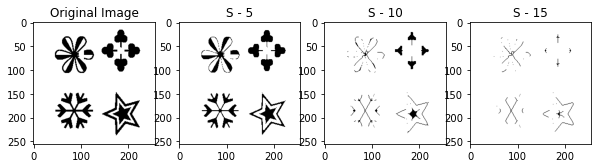

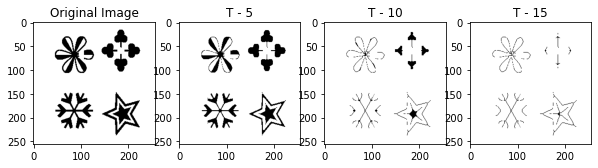

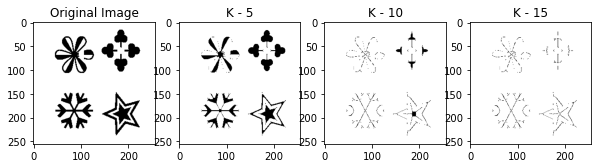

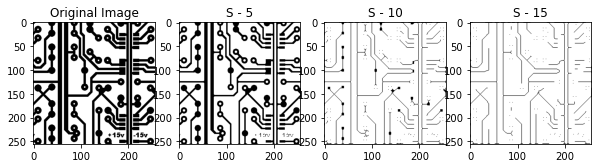

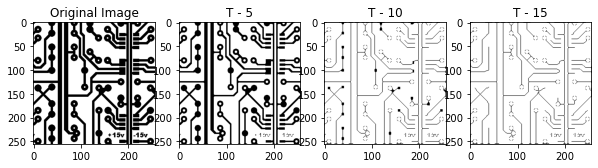

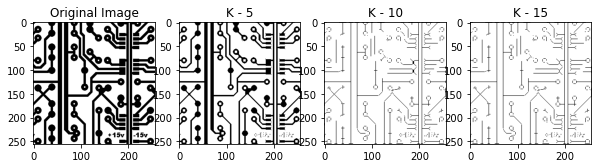

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

def load_image(file_path):
    size = 256
    threshold = 128
    imagedata = np.fromfile(file_path, dtype=np.uint8, count=size*size).reshape(size, size)
    imagedata = (imagedata < threshold).astype(np.uint8)
    return imagedata


def padding(image, pad_value):
    size = image.shape[0]
    pad_size = 4  # 9 // 2
    pad_image_size = size + 2 * pad_size
    # Create padded image and insert the original image
    pad_image = np.full((pad_image_size, pad_image_size), pad_value, dtype=image.dtype)
    pad_image[pad_size:pad_size + size, pad_size:pad_size + size] = image
    return pad_image
def conditional(image, size, array):
    cond = image.copy()
    cond = padding(cond, 0)

    for i in range(1, size - 1):
        for j in range(1, size - 1):
            if image[i, j] == 1:
                check = image[i, j]*(2**0) + image[i + 1, j]*(2**1) + image[i + 1, j + 1]*(2**2) + image[i, j + 1]*(2**3) + image[i - 1, j + 1]*(2**4) + image[i - 1, j]*(2**5) + image[i - 1, j - 1]*(2**6) + image[i, j - 1]*(2**7) + image[i + 1, j - 1]*(2**8)
                if check in array:
                    cond[i, j] = 2
                else:
                    continue
            else:
                continue

    return cond

def cond_shrinking():
    st_4 = np.array([[[0, 2, 2], [2, 2, 0], [0, 0, 0]], [[2, 2, 0], [0, 2, 2], [0, 0, 0]], [[0, 2, 0], [0, 2, 2], [0, 0, 2]], [[0, 0, 2], [0, 2, 2], [0, 2, 0]]])
    spur = np.array([[[0, 0, 2], [0, 2, 0], [0, 0, 0]], [[2, 0, 0], [0, 2, 0], [0, 0, 0]]])
    st_single = np.array([[[0, 0, 0], [0, 2, 0], [0, 2, 0]], [[0, 0, 0], [0, 2, 2], [0, 0, 0]]])
    corner = np.array([[[0, 1, 2], [0, 2, 0], [2, 0, 0]], [[0, 1, 2], [0, 2, 1], [2, 0, 0]], [[0, 0, 2], [0, 2, 1], [2, 0, 0]], [[2, 1, 0], [0, 2, 0], [0, 0, 2]], [[2, 1, 0], [1, 2, 0], [0, 0, 2]], [[2, 0, 0], [1, 2, 0], [0, 0, 2]], [[0, 0, 2], [1, 2, 0], [2, 0, 0]], [[0, 0, 2], [1, 2, 0], [2, 1, 0]], [[0, 0, 2], [0, 2, 0], [2, 1, 0]], [[2, 0, 0], [0, 2, 1], [0, 0, 2]], [[2, 0, 0], [0, 2, 1], [0, 1, 2]], [[2, 0, 0], [0, 2, 0], [0, 1, 2]]])
    corner2 = np.array([[[2, 2, 1], [2, 2, 1], [1, 1, 1]], [[2, 2, 0], [2, 2, 0], [0, 0, 0]]])
    tee = np.array([[[1, 2, 0], [2, 2, 2], [1, 0, 0]], [[0, 2, 0], [2, 2, 2], [0, 0, 0]], [[0, 2, 1], [2, 2, 2], [0, 0, 1]], [[0, 0, 1], [2, 2, 2], [0, 2, 1]], [[0, 0, 0], [2, 2, 2], [0, 2, 0]], [[1, 0, 0], [2, 2, 2], [1, 2, 0]], [[1, 2, 1], [2, 2, 0], [0, 2, 0]], [[0, 2, 0], [2, 2, 0], [0, 2, 0]], [[0, 2, 0], [2, 2, 0], [1, 2, 1]], [[0, 2, 0], [0, 2, 2], [1, 2, 1]], [[0, 2, 0], [0, 2, 2], [0, 2, 0]], [[1, 2, 1], [0, 2, 2], [0, 2, 0]]])
    diagonal = np.array([[[1, 2, 0], [0, 2, 2], [2, 0, 1]], [[0, 2, 0], [0, 2, 2], [2, 0, 0]], [[0, 2, 1], [2, 2, 0], [1, 0, 2]], [[0, 2, 0], [2, 2, 0], [0, 0, 2]], [[1, 0, 2], [2, 2, 0], [0, 2, 1]], [[0, 0, 2], [2, 2, 0], [0, 2, 0]], [[2, 0, 1], [0, 2, 2], [1, 2, 0]], [[2, 0, 0], [0, 2, 2], [0, 2, 0]]])
    vee = []
    for D in [0, 1]:
        for A in [0, 1]:
            for B in [0, 1]:
                for C in [0, 1]:
                    if A == 1 or B == 1 or C == 1:
                        matrix = [[2, D, 2], [D, 2, D], [A, B, C]]
                        matrix2 = [[2, D, C], [D, 2, B], [2, D, A]]
                        matrix3 = [[C, B, A], [D, 2, D], [2, D, 2]]
                        matrix4 = [[A, D, 2], [B, 2, D], [C, D, 2]]
                        vee.extend([matrix, matrix2, matrix3, matrix4])
    vee = np.stack(vee, axis=0)
    return np.concatenate([st_4, spur, st_single, corner, corner2, tee, diagonal, vee])

def th_conditional():
    shrink = cond_shrinking()
    t = np.array([[[0, 0, 2], [0, 2, 2], [0, 0, 0]], [[0, 2, 2], [0, 2, 0], [0, 0, 0]],
           [[2, 2, 0], [0, 2, 0], [0, 0, 0]], [[2, 0, 0], [2, 2, 0], [0, 0, 0]],
           [[0, 0, 0], [2, 2, 0], [2, 0, 0]], [[0, 0, 0], [0, 2, 0], [2, 2, 0]],
           [[0, 0, 0], [0, 2, 0], [0, 2, 2]], [[0, 0, 0], [0, 2, 2], [0, 0, 2]]])
    return np.concatenate([shrink, t])

def skeleton():
    spur = np.array([[[0, 0, 2], [0, 2, 0], [0, 0, 0]], [[2, 0, 0], [0, 2, 0], [0, 0, 0]], [[0, 0, 0], [0, 2, 0], [0, 0, 2]], [[0, 0, 0], [0, 2, 0], [2, 0, 0]]])
    single = np.array([[[0, 0, 0], [0, 2, 0], [0, 2, 0]], [[0, 0, 0], [0, 2, 2], [0, 0, 0]], [[0, 2, 0], [0, 2, 0], [0, 0, 0]], [[0, 0, 0], [2, 2, 0], [0, 0, 0]]])
    corner = np.array([[[0, 2, 0], [0, 2, 2], [0, 0, 0]], [[0, 2, 0], [2, 2, 0], [0, 0, 0]], [[0, 0, 0], [0, 2, 2], [0, 2, 0]], [[0, 0, 0], [2, 2, 0], [0, 2, 0]]])
    corner2 = np.array([[[2, 2, 1], [2, 2, 1], [1, 1, 1]], [[2, 2, 0], [2, 2, 0], [0, 0, 0]], [[1, 1, 1], [1, 2, 2], [1, 2, 2]], [[0, 0, 0], [0, 2, 2], [0, 2, 2]]])
    tee = np.array([[[1, 2, 1], [2, 2, 2], [1, 1, 1]], [[0, 2, 0], [2, 2, 2], [0, 0, 0]], [[1, 2, 1], [2, 2, 1], [1, 2, 1]], [[0, 2, 0], [2, 2, 0], [0, 2, 0]], [[1, 2, 1], [1, 2, 2], [1, 2, 1]], [[0, 2, 0], [0, 2, 2], [0, 2, 0]], [[1, 1, 1], [2, 2, 2], [1, 2, 1]], [[0, 0, 0], [2, 2, 2], [0, 2, 0]]])
    diagonal = np.array([[[1, 2, 0], [0, 2, 2], [2, 0, 1]], [[0, 2, 0], [0, 2, 2], [2, 0, 0]], [[0, 2, 1], [2, 2, 0], [1, 0, 2]], [[0, 2, 0], [2, 2, 0], [0, 0, 2]], [[1, 0, 2], [2, 2, 0], [0, 2, 1]], [[0, 0, 2], [2, 2, 0], [0, 2, 0]], [[2, 0, 1], [0, 2, 2], [1, 2, 0]], [[2, 0, 0], [0, 2, 2], [0, 2, 0]]])
    vee = []
    for D in [0, 1]:
        for A in [0, 1]:
            for B in [0, 1]:
                for C in [0, 1]:
                    if A == 1 or B == 1 or C == 1:
                        matrix = [[2, D, 2], [D, 2, D], [A, B, C]]
                        matrix2 = [[2, D, C], [D, 2, B], [2, D, A]]
                        matrix3 = [[C, B, A], [D, 2, D], [2, D, 2]]
                        matrix4 = [[A, D, 2], [B, 2, D], [C, D, 2]]
                        vee.extend([matrix, matrix2, matrix3, matrix4])
    vee = np.stack(vee, axis=0)
    return np.concatenate([single, spur, corner, corner2, tee, diagonal, vee])

def uncond(orig, image, kind):
    orig = np.array(orig)
    image = np.array(image)

    def apply_mask_and_update_original(cond_masks):
        for mask in cond_masks:
            mask_array = np.array(mask)
            for i in range(image.shape[0] - mask_array.shape[0] + 1):
                for j in range(image.shape[1] - mask_array.shape[1] + 1):
                    if image[i + 1, j + 1] == 2:
                        section = image[i:i + mask_array.shape[0], j:j + mask_array.shape[1]]
                        if not np.array_equal(section, mask_array):
                            orig[i + 1, j + 1] = 0
                        elif kind == 1:
                            orig[i + 1, j + 1] = 1

    if kind == 1:
        shrink_cond = cond_shrinking()
        apply_mask_and_update_original(shrink_cond)
    elif kind == 2:
        thin_cond = th_conditional()
        apply_mask_and_update_original(thin_cond)
    elif kind == 3:
        skeleton_cond = skeleton()
        apply_mask_and_update_original(skeleton_cond)

    return orig

def reverse(image):
    hello = image.copy()
    image = (hello == 0).astype(np.uint8)
    return image
def shrink(orig):
    s = [5, 17, 65, 257, 3, 9, 33, 129, 7, 13, 25, 49, 97, 193, 385, 259, 263, 29, 113, 449, 27, 267, 45, 135, 15, 57, 225, 387, 283, 109, 31, 271, 61, 121, 241, 481, 451, 391, 287, 125, 497, 455, 399, 63, 249, 483, 415, 463, 127, 319, 253, 505, 499, 487, 479, 383, 509, 503]
    image = orig.copy()
    out_size = 256
    kind = 1
    cond = conditional(image, out_size, s)
    image = uncond(image, cond, kind)

    return image
def thin(orig):
    t = [11, 41, 161, 131, 263, 29, 113, 449, 27, 267, 45, 135, 15, 57,
         225, 387, 283, 109, 31, 271, 61, 121, 241, 481, 451, 391, 287, 125, 497, 455, 399, 63, 249, 483, 415, 463, 127,
         319, 253, 505, 499, 487, 479, 383, 509, 503]
    image = orig.copy()
    out_size = 256
    kind = 2

    cond = conditional(image, out_size, t)
    image = uncond(image, cond, kind)
    return image


def skelet(orig):
    k = [11, 41, 161, 131, 263, 29, 113, 449, 31, 271, 61, 121, 241, 481, 451, 391, 287, 125, 497, 455, 399, 63, 249, 483, 415, 463, 127,
         319, 253, 505, 499, 487, 479, 383, 509, 503, 447, 255, 507, 495]
    image = orig.copy()
    size, size = image.shape
    out_size = 256
    kind = 3

    cond = conditional(image, out_size, k)
    image = uncond(image, cond, kind)

    return image

patterns = load_image(r"./Project2_Images/patterns.raw")


def apply_process_and_reverse(process_function, input_data, steps):
    result = process_function(input_data.copy())
    reversed_result = [reverse(result.copy())]

    for _ in range(steps - 1):
        result = process_function(result)
        if (_ + 1) in [4, 9]:
            reversed_result.append(reverse(result.copy()))

    return reversed_result

shrunk_results = apply_process_and_reverse(shrink, patterns, 10)
thin_results = apply_process_and_reverse(thin, patterns, 10)
skeleton_results = apply_process_and_reverse(skelet, patterns, 10)

def plot_results(results, title_prefix, original_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(141), plt.imshow(reverse(original_image.copy()), cmap='gray'), plt.title('Original Image')
    for i, result in enumerate(results, start=1):
        plt.subplot(141 + i), plt.imshow(result, cmap='gray'), plt.title(f'{title_prefix} - {i*5}')
    plt.show()

plot_results(shrunk_results, 'S', patterns)
plot_results(thin_results, 'T', patterns)
plot_results(skeleton_results, 'K', patterns)



pcb = load_image(r"./Project2_Images/pcb.raw")
pcb_data = pcb.copy()  # Assuming pcb is defined elsewhere in your code

# Applying the processes
shrunk_results = apply_process_and_reverse(shrink, pcb_data, 10)
thin_results = apply_process_and_reverse(thin, pcb_data, 10)
skeleton_results = apply_process_and_reverse(skelet, pcb_data, 10)

# Plotting the results
plot_results(shrunk_results, 'S', pcb_data)
plot_results(thin_results, 'T', pcb_data)
plot_results(skeleton_results, 'K', pcb_data)

<h3>Problem 3: Digital Halftoning</h3>
<p>There are 256 gray levels for pixels in Figure 4 (barbara.raw). Please implement the following
four procedures to convert barbara.raw to a binary image. In the following discussion, F(i,j) and
G(i,j) denote the pixel of the input and the output images at position (i,j), respectively.<span style="color:red">compare
the results obtained from these four algorithms in your report.</span>.</p>

<h4>(a) Fixed Threshold Dithering</h4>
<p>1. Choose one value, T, as the threshold to divide the 256 levels into two ranges. An
intuitive choice of T would be 127.
2. For each pixel, map it to 0 if it is smaller than T, otherwise, map it to 255.</p>


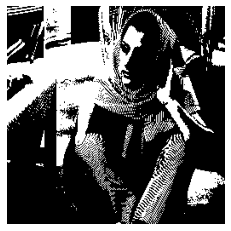

In [13]:
#(a) Fixed Threshold Dithering
import numpy as np
import matplotlib.pyplot as plt

# Complete Python code to implement Fixed Threshold Dithering on the 'barbara.raw' image

# Define the threshold T
T = 127

# Read the raw image data
image_path = "./Project2_Images/barbara.raw"
# We now know the image size is 256x256 from the previous attempt
image_size = 256

# Load the image data
with open(image_path, 'rb') as file:
    img_data = np.fromfile(file, dtype=np.uint8)
    img_data = img_data.reshape((image_size, image_size))

# Apply fixed threshold dithering
binary_img = np.where(img_data < T, 0, 255)

# Display the binary image
plt.imshow(binary_img, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


<h4>(b) Random Dithering</h4>
<p>The algorithm can be described as:
1. For each pixel, generate a random number in the range 0 ~ 255, so called rand (i, j)
2. Compare the pixel value with the correspond
255; otherwise, map it to 0</p>

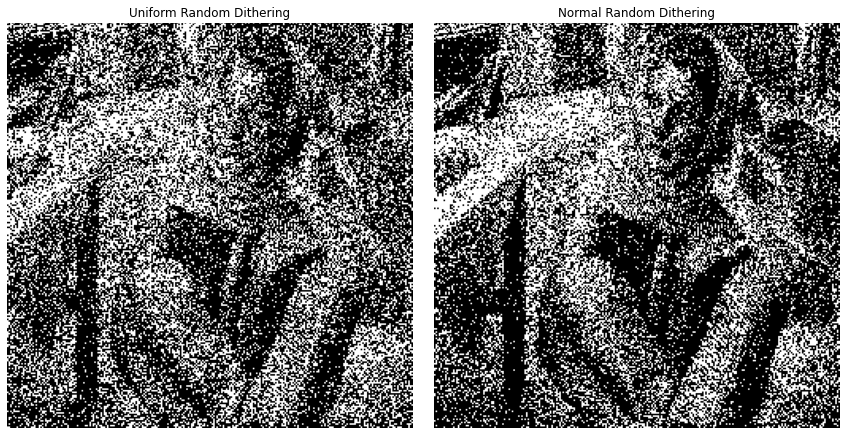

In [56]:
#(b) Random Dithering
import numpy as np
import matplotlib.pyplot as plt


# Load the image data
image_path = './Project2_Images/barbara.raw'
image_size = 256  # Image dimensions (256x256)

with open(image_path, 'rb') as file:
    img_data = np.fromfile(file, dtype=np.uint8).reshape((image_size, image_size))

# Function to perform random dithering using a uniform distribution
def random_dithering_uniform(image_data):
    random_threshold = np.random.randint(0, 256, image_data.shape)
    return np.where(image_data < random_threshold, 0, 255)

# Function to perform random dithering using a normal distribution
def random_dithering_normal(image_data):
    # Generate random numbers with a mean of 127 and std deviation such that most values fall within 0-255
    random_threshold = np.random.randn(*image_data.shape) * 64 + 127
    random_threshold = np.clip(random_threshold, 0, 255)  # Clip to ensure values are within range
    return np.where(image_data < random_threshold, 0, 255)

# Perform random dithering with both distributions
binary_img_uniform = random_dithering_uniform(img_data)
binary_img_normal = random_dithering_normal(img_data)

# Display the binary images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Uniform random dithering
ax[0].imshow(binary_img_uniform, cmap='gray')
ax[0].set_title('Uniform Random Dithering')
ax[0].axis('off')

# Normal random dithering
ax[1].imshow(binary_img_normal, cmap='gray')
ax[1].set_title('Normal Random Dithering')
ax[1].axis('off')

plt.tight_layout()
plt.show()


<h4>(c) Dithering Matrix (Pattern)<h4>
<p>Dithering parameters are specified by an index matrix. The values in an index matrix indicate
how likely a dot will be turned on.</p>

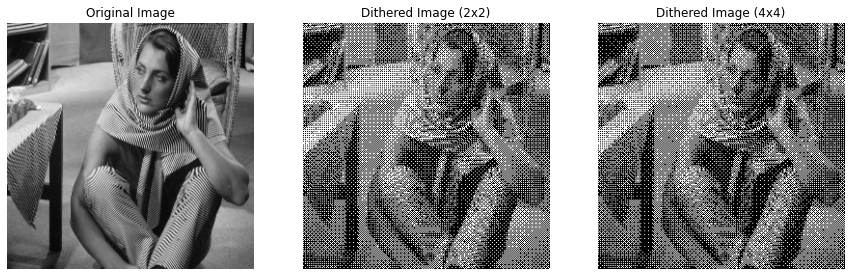

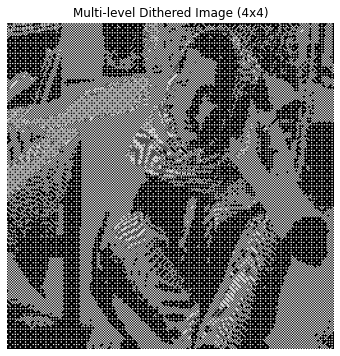

In [40]:
#(c) Dithering Matrix (Pattern)
import numpy as np
import matplotlib.pyplot as plt

# Function to load the raw image file and convert it into a numpy array
def load_raw_image(file_path, size=(256, 256)):
    with open(file_path, 'rb') as file:
        img = np.fromfile(file, dtype=np.uint8)
        img = img.reshape(size)
    return img

# Function to create the Bayer dithering matrix recursively
def bayer_matrix(order):
    if order == 1:
        return np.array([[0, 2], [3, 1]], dtype=np.float32)
    else:
        smaller_matrix = bayer_matrix(order // 2)
        four_times_smaller_matrix = 4 * smaller_matrix
        new_matrix = np.block([
            [four_times_smaller_matrix, four_times_smaller_matrix + 2],
            [four_times_smaller_matrix + 3, four_times_smaller_matrix + 1]
        ])
        return new_matrix

# Function to dither the image using a threshold matrix
def dither_image(image, threshold_matrix):
    noise = threshold_matrix.shape[0]
    threshold_matrix = threshold_matrix / (noise * noise) * 255
    tiled_matrix = np.tile(threshold_matrix, (image.shape[0] // noise, image.shape[1] // noise))
    return np.where(image > tiled_matrix, 255, 0)

# Load the Barbara image
barbara_image = load_raw_image('./Project2_Images/barbara.raw')

# Create the 2x2 and 4x4 Bayer matrices
bayer_2x2 = bayer_matrix(2)
bayer_4x4 = bayer_matrix(4)

# Dither the Barbara image using the 2x2 and 4x4 Bayer matrices
dithered_barbara_2x2 = dither_image(barbara_image, bayer_2x2)
dithered_barbara_4x4 = dither_image(barbara_image, bayer_4x4)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(barbara_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(dithered_barbara_2x2, cmap='gray')
axes[1].set_title('Dithered Image (2x2)')
axes[1].axis('off')

axes[2].imshow(dithered_barbara_4x4, cmap='gray')
axes[2].set_title('Dithered Image (4x4)')
axes[2].axis('off')

plt.show()

def multi_level_dither_image(image, threshold_matrix, levels=4):
    noise = threshold_matrix.shape[0]
    max_val = 255
    step = max_val // (levels - 1)

    # Normalize and scale the threshold matrix to match the intensity levels
    threshold_matrix = np.round(threshold_matrix / (noise * noise) * (levels - 1)) * step
    tiled_matrix = np.tile(threshold_matrix, (image.shape[0] // noise, image.shape[1] // noise))

    # Apply dithering to map image to nearest intensity levels
    dithered_image = np.zeros_like(image)
    for i in range(levels):
        lower_bound = i * step
        upper_bound = (i + 1) * step
        dithered_image = (dithered_image + 
                          np.where((image > tiled_matrix) & (image <= upper_bound), 
                                   i * step, 0).astype(np.uint8))

    return dithered_image

# Apply the multi-level dithering to the Barbara image using a 4x4 Bayer matrix
multi_level_dithered_barbara = multi_level_dither_image(barbara_image, bayer_4x4, levels=4)

# Plot the multi-level dithered image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(multi_level_dithered_barbara, cmap='gray')
ax.set_title('Multi-level Dithered Image (4x4)')
ax.axis('off')
plt.show()


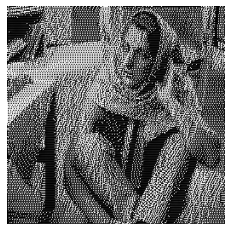

In [33]:
#(d) Implement Floyd-Steinberg's error diffusion with serpentine scanning
import numpy as np
import matplotlib.pyplot as plt

# Load the image file
file_path = './Project2_Images/barbara.raw'
with open(file_path, 'rb') as file:
    image_data = np.fromfile(file, dtype=np.uint8)
    size = int(np.sqrt(image_data.size))  # Assuming the image is square
    image = image_data.reshape((size, size))

# Floyd-Steinberg's error diffusion algorithm with serpentine scanning
def floyd_steinberg_dither(image):
    height, width = image.shape
    for y in range(height):
        if y % 2 == 0:  # Left to right on even rows
            x_range = range(width)
        else:  # Right to left on odd rows
            x_range = range(width - 1, -1, -1)

        for x in x_range:
            old_pixel = image[y, x]
            new_pixel = 255 if old_pixel > 127 else 0
            image[y, x] = new_pixel
            error = old_pixel - new_pixel

            if x + 1 < width:
                image[y, x + 1] += error * 7 / 16
            if x - 1 >= 0 and y + 1 < height:
                image[y + 1, x - 1] += error * 3 / 16
            if y + 1 < height:
                image[y + 1, x] += error * 5 / 16
            if x + 1 < width and y + 1 < height:
                image[y + 1, x + 1] += error * 1 / 16

    return image

# Apply the algorithm
dithered_image = floyd_steinberg_dither(image.copy())

# Plot the final image
plt.imshow(dithered_image, cmap='gray')
plt.axis('off')
plt.show()
